<a href="https://colab.research.google.com/github/Etienne982/AI-in-aviation/blob/main/Main_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime, warnings, scipy
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor='dimgray', linewidth=1)

warnings.filterwarnings("ignore")

# Loading the data
df = pd.read_csv('flights.csv', low_memory=False)

df['DATE'] = pd.to_datetime(df[['year', 'month', 'day']])

#_________________________________________________________
# Function that converts 'HHMM' (int) or 'HH:MM' (str) to minutes
def convert_to_minutes(hourminute):
    """ Converts HHMM (int) or HH:MM (str) to minutes """
    if pd.isna(hourminute):
        return np.nan
    if isinstance(hourminute, str):  # Check if it's already a string in HH:MM format
        try:
            hours, minutes = map(int, hourminute.split(":"))
            return hours * 60 + minutes
        except ValueError:
            return np.nan
    if hourminute == 2400:  # Special case for 2400
        return 0
    hourminute = str(int(hourminute)).zfill(4)
    hours = int(hourminute[:2])
    minutes = int(hourminute[2:])
    return hours * 60 + minutes

# Apply the conversion to minutes
df['sched_dep_time'] = df['sched_dep_time'].apply(convert_to_minutes)
df['sched_arr_time'] = df['sched_arr_time'].apply(convert_to_minutes)
df['dep_time'] = df['dep_time'].apply(convert_to_minutes)
df['arr_time'] = df['arr_time'].apply(convert_to_minutes)

# Calculate scheduled and actual times in minutes
df['sched_time'] = df['sched_arr_time'] - df['sched_dep_time']
df['elapse_time'] = df['arr_time'] - df['dep_time']

# Cleaning up unnecessary columns
variables_to_remove = ['name', 'time_hour', 'minute', 'hour',
                       'distance', 'flight', 'tailnum', 'air_time']
df.drop(columns=variables_to_remove, inplace=True, errors='ignore')

# Reorganizing columns
df = df[['year','month','day','carrier', 'origin', 'dest',
         'sched_dep_time', 'dep_time', 'dep_delay',
         'sched_arr_time', 'arr_time', 'arr_delay',
         'sched_time', 'elapse_time']]

# Dropping rows with missing values
df.dropna(inplace=True)

# Creating a DataFrame with statistics for each airline
def get_stats(group):
    """ Extracts statistics: min, max, count, and mean """
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

global_stats = df['dep_delay'].groupby(df['carrier']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')

# Counting the percentage of data for each carrier
carrier_data_count = df['carrier'].value_counts()  # Count of each carrier
carrier_percentage = (carrier_data_count / len(df)) * 100  # Percentage calculation

# Displaying carrier percentages
print("\nCarrier data percentage distribution:")
print(carrier_percentage)

# Saving the cleaned DataFrame
df.to_csv('flight_data.csv', index=False)  # Saving cleaned data
print("The cleaned data has been saved as 'flight_data.csv'.")

# Checking global statistics
global_stats



Carrier data percentage distribution:
carrier
UA    17.651659
B6    16.511276
EV    15.612838
DL    14.558907
AA     9.759398
MQ     7.648482
US     6.058116
9E     5.283095
WN     3.679287
VX     1.562872
FL     0.969922
AS     0.216590
F9     0.208037
YV     0.166185
HA     0.104477
OO     0.008859
Name: count, dtype: float64
The cleaned data has been saved as 'flight_data.csv'.


,min,max,count,mean
carrier,,,,
OO,-14.0,154.0,29.0,12.586207
HA,-16.0,1301.0,342.0,4.900585
YV,-16.0,387.0,544.0,18.898897
F9,-27.0,853.0,681.0,20.201175
AS,-21.0,225.0,709.0,5.830748
FL,-22.0,602.0,3175.0,18.605984
VX,-20.0,653.0,5116.0,12.756646
WN,-13.0,471.0,12044.0,17.661657
9E,-24.0,747.0,17294.0,16.439574


This script performs data cleaning, transformation, and preliminary statistical analysis on a dataset of flights. Here's a breakdown of its functionality:

**1. Libraries and Setup**

The script uses standard libraries like pandas, numpy, and matplotlib for data manipulation and visualization.
Warnings are suppressed for cleaner output, and the visualization style is set to 'fivethirtyeight'.

**2. Loading the Dataset**

Data Source:

A CSV file named flights.csv is loaded with low_memory=False to avoid dtype inference issues for large datasets.

Date Column:
 A DATE column is created by combining the year, month, and day columns into a datetime object.

**3. Time Conversion**

Function: convert_to_minutes(hourminute) converts time formats like HHMM (e.g., 1245) or HH:MM (e.g., 12:45) into total minutes since midnight.

Special Cases:
2400 is treated as 0 (midnight).

Invalid values or NaN return NaN.

Application: The function is applied to scheduled and actual departure/arrival times.

**4. Feature Engineering**

Scheduled and Elapsed Times:
* sched_time: Difference between scheduled arrival and departure times.
* elapse_time: Difference between actual arrival and departure times.

Unnecessary Columns: Columns like name, time_hour, and tailnum are dropped as they are not relevant for analysis.

**5. Data Cleaning**

The script removes rows with missing values to ensure the dataset is complete and ready for analysis.

**6. Reorganizing Columns**

The columns are reordered for better readability and logical grouping:

Flight information (year, month, day, carrier, origin, dest).

Scheduled and actual times (sched_dep_time, dep_time, dep_delay, etc.).

**7. Statistical Analysis**

Per Carrier Statistics:
* Function: get_stats(group) computes minimum, maximum, count, and mean departure delays for each airline (carrier).

The results are sorted by the number of flights for each carrier (count).

Carrier Data Distribution:
* Percentage of flights for each carrier is calculated and displayed.

**8. Saving Cleaned Data**

The cleaned and transformed dataset is saved as flight_data.csv for further analysis or modeling.

**9. Output**

Carrier Data Distribution:
* Provides the percentage of flights operated by each airline.

Global Statistics:
* Displays delay-related statistics (min, max, count, mean) for each airline.

Please enter the airline code (e.g., 'AA', 'DL', etc.): UA
Checking for missing values:
heure_depart        0
heure_arrivee       0
origin              0
dep_delay        3854
weekday             0
dtype: int64

After removing NaN in dep_delay:
heure_depart     0
heure_arrivee    0
origin           0
dep_delay        0
weekday          0
dtype: int64

X (features) after transformation:
[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
Y (target) after transformation:
[[ 2.]
 [ 4.]
 [-4.]
 [-2.]
 [-2.]]
n=1 alpha=0.0 , MSE = 176.24
n=1 alpha=0.2 , MSE = 176.25
n=1 alpha=0.4 , MSE = 176.25
n=1 alpha=0.6 , MSE = 176.25
n=1 alpha=0.8 , MSE = 176.25
n=1 alpha=1.0 , MSE = 176.25
n=1 alpha=1.2 , MSE = 176.25
n=1 alpha=1.4 , MSE = 176.25
n=1 alpha=1.6 , MSE = 176.25
n=1 alpha=1.8 , MSE = 176.25
n=2 alpha=0.0 , MSE = 176.26
n=2 alpha=0.2 , MSE = 176.25
n=2 alpha=0.4 , MSE = 176.25
n=2 alpha=0.6 , MSE = 176.25
n=2 alpha=0.8 , MSE = 176.25
n=2 alpha=1.0 , 

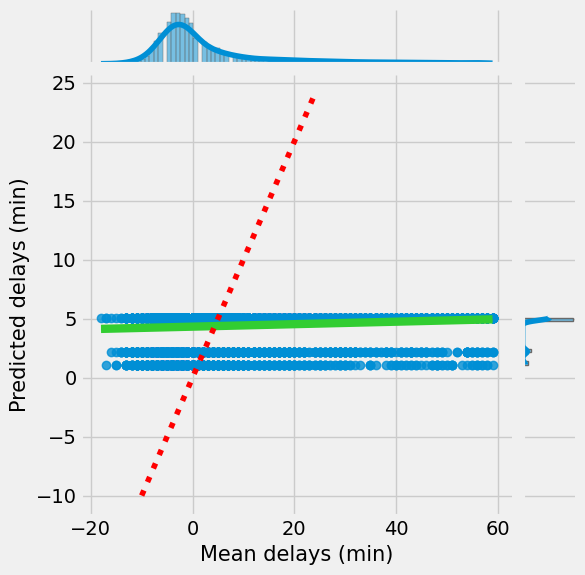

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

def create_df(df, carrier):
    # Filtering by airline
    df2 = df[df['carrier'] == carrier][['year', 'month', 'day', 'sched_dep_time', 'sched_arr_time', 'origin', 'dest', 'dep_delay']]

    # Converting time columns to datetime if they are not already
    df2['sched_dep_time'] = pd.to_datetime(df2['sched_dep_time'], errors='coerce')
    df2['sched_arr_time'] = pd.to_datetime(df2['sched_arr_time'], errors='coerce')

    # Calculating the weekday based on the date, Monday = 1, Sunday = 7
    df2['weekday'] = pd.to_datetime(df2[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d').dt.weekday + 1

    # Removing departures with delays > 1 hour (optional based on your request)
    df2['dep_delay'] = df2['dep_delay'].apply(lambda x: x if x < 60 else np.nan)

    # Keeping just the information without additional aggregation
    df3 = df2[['sched_dep_time', 'sched_arr_time', 'origin', 'dep_delay', 'weekday']]

    # Converting times to seconds after creating the dataframe
    df3['heure_depart'] = df3['sched_dep_time'].apply(lambda x: x.hour * 3600 + x.minute * 60)
    df3['heure_arrivee'] = df3['sched_arr_time'].apply(lambda x: x.hour * 3600 + x.minute * 60)

    # Dropping the original time columns
    df3 = df3.drop(columns=['sched_dep_time', 'sched_arr_time'])

    # Reorganizing the column order
    df3 = df3[['heure_depart', 'heure_arrivee', 'origin', 'dep_delay', 'weekday']]

    return df3


# Example of usage
carrier = input("Please enter the airline code (e.g., 'AA', 'DL', etc.): ")
df3 = create_df(df, carrier)

# Checking for NaN values in the dataframe
print("Checking for missing values:")
print(df3.isna().sum())

# Removing rows with NaN in 'dep_delay' if necessary
df3 = df3.dropna(subset=['dep_delay'])

# Checking after removing NaN values
print("\nAfter removing NaN in dep_delay:")
print(df3.isna().sum())

# Label Encoding for the 'origin' column
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df3['origin'])

# One-Hot Encoding with the correct parameter
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

# Combine data into X and Y
b = np.array(df3[['heure_depart', 'heure_arrivee']])
X = np.hstack((onehot_encoded, b))
Y = np.array(df3['dep_delay'])
Y = Y.reshape(len(Y), 1)

# Verifying the final data
print("\nX (features) after transformation:")
print(X[:5])  # Displaying the first 5 rows of X
print("Y (target) after transformation:")
print(Y[:5])  # Displaying the first 5 rows of Y

# Splitting into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

# Normalizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initializing variables to search for the best parameters
score_min = 10000
for pol_order in range(1, 3):
    for alpha in range(0, 20, 2):
        ridgereg = Ridge(alpha=alpha/10)
        poly = PolynomialFeatures(degree=pol_order)
        X_poly_train = poly.fit_transform(X_train_scaled)
        ridgereg.fit(X_poly_train, Y_train)

        X_poly_test = poly.transform(X_test_scaled)
        result = ridgereg.predict(X_poly_test)
        score = metrics.mean_squared_error(result, Y_test)

        if score < score_min:
            score_min = score
            parameters = [alpha, pol_order]

        print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha/10, score))


ridgereg = Ridge(alpha=parameters[0])
poly = PolynomialFeatures(degree=parameters[1])

# Normalizing the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Polynomial transformation for X_train
X_poly_train = poly.fit_transform(X_train_scaled)
ridgereg.fit(X_poly_train, Y_train)

# Predicting on transformed X_test
X_poly_test = poly.transform(X_test_scaled)
predictions = ridgereg.predict(X_poly_test)

# Calculating the error using the mean squared error
print('Error = {:.2f} min'.format(np.sqrt(score)))

# Calculating the number of errors greater than 15 minutes
icount = 0
for i, val in enumerate(Y_test):
    if abs(val - predictions[i]) > 15:  # Comparing with 15 minutes
        icount += 1

# Displaying the percentage of errors greater than 15 minutes
print("Errors > 15 minutes: {}%".format(round((icount / len(predictions)) * 100, 3)))

# MSE on the test data
score = metrics.mean_squared_error(predictions, Y_test)
print('MSE on the test data: {:.2f}'.format(score))

# Creating a DataFrame for predictions and original values
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in predictions])
tips["original_data"] = pd.Series([float(s) for s in Y_test])

# Displaying the jointplot with adjusted size
sns.jointplot(x="original_data", y="prediction", data=tips, height=6, ratio=7,
              joint_kws={'line_kws': {'color': 'limegreen'}}, kind='reg')

# Adding labels on the axes
plt.xlabel('Mean delays (min)', fontsize=15)
plt.ylabel('Predicted delays (min)', fontsize=15)

# Plotting a reference line
plt.plot(list(range(-10, 25)), list(range(-10, 25)), linestyle=':', color='r')

# Displaying the plot
plt.show()


This code is our first attempt at training a model, here is how it works:

**1. Importing Libraries**

The required libraries are imported:
* pandas, numpy: For data manipulation.
* sklearn: For data preprocessing, regression model, and evaluation metrics.
* seaborn, matplotlib: For visualizing the results.

**2. Function create_df**

This function filters the data for a specific airline and transforms relevant columns:

* Filtering: Selects flights for the specified airline passed as a parameter.
* Time Conversion: Converts sched_dep_time and sched_arr_time columns into datetime objects.
* Adding Day of the Week: Calculates the weekday for each flight.
* Filtering Delays: Ignores delays greater than 60 minutes (optional).
* Converting Times to Seconds: Transforms departure and arrival times into seconds since midnight for easier processing.

**3. Data Preprocessing**

Removing NaN Values: Rows with missing delays (dep_delay) are removed.

Encoding Categorical Variables:
* The origin column (origin airport) is encoded as integers (Label Encoding).
* These integer values are then converted into binary vectors (One-Hot Encoding) to avoid bias in the model.

**4. Building Input and Output Data**

X (features): Combines the encoded variables (origin airports) with departure and arrival times.

Y (target): Corresponds to delays (dep_delay).

**5. Data Splitting**

The data is split into training and testing sets (70% training, 30% testing).

**6. Data Normalization**

Features are standardized using StandardScaler to ensure all variables are on the same scale (important for regression models).

**7. Hyperparameter Search**

A hyperparameter search is performed for:

* degree (polynomial order): Tests polynomial transformations of order 1 and 2.
* alpha (Ridge regularization parameter): Explores different values to reduce overfitting.

For each combination:

1. The Ridge model is trained.
2. The MSE (Mean Squared Error) is calculated on the test set.
3. The best parameters are recorded based on the minimum MSE.

**8. Retraining with Best Parameters**

Once the best parameters are identified:

The model is retrained on the training set with these optimal parameters.
Predictions are generated on the test set.

**9. Performance Evaluation**

* MSE: The Mean Squared Error is calculated on the predictions.
* Errors > 15 Minutes: The percentage of predictions with errors exceeding 15 minutes is calculated.
* Visualization:
  * A regression plot (jointplot) is created to compare actual and predicted delays.
  * A reference line is added to visualize ideal predictions.

Epoch 1/100
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1603.0873 - val_loss: 1582.2299
Epoch 2/100
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 1562.6781 - val_loss: 1550.6537
Epoch 3/100
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 1510.3733 - val_loss: 1534.8961
Epoch 4/100
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1540.1974 - val_loss: 1534.0071
Epoch 5/100
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 1527.7679 - val_loss: 1525.7505
Epoch 6/100
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1516.6967 - val_loss: 1522.0480
Epoch 7/100
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 1508.7714 - val_loss: 1512.3080
Epoch 8/100
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 1506.8680 - val_loss: 1510.0182
Epoch 9/100
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1517.5082 - val_loss: 1503.1729
Epoch 10/100
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1505.7958 - val_loss: 1503.4149
Epoch 11/100
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 9

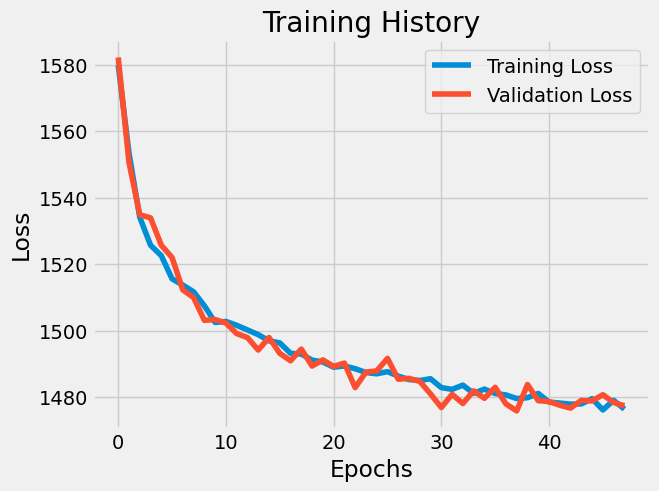

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Load flight data
df = pd.read_csv('flight_data.csv')

# Encode categorical variables
label_encoder_origin = LabelEncoder()
label_encoder_dest = LabelEncoder()

df['origin_encoded'] = label_encoder_origin.fit_transform(df['origin'])
df['dest_encoded'] = label_encoder_dest.fit_transform(df['dest'])

# Create new features
df['sched_dep_time'] = pd.to_datetime(df['sched_dep_time'], errors='coerce').dt.hour * 3600 + pd.to_datetime(df['sched_dep_time'], errors='coerce').dt.minute * 60
df['sched_arr_time'] = pd.to_datetime(df['sched_arr_time'], errors='coerce').dt.hour * 3600 + pd.to_datetime(df['sched_arr_time'], errors='coerce').dt.minute * 60

df['day_of_week'] = pd.to_datetime(df[['year', 'month', 'day']]).dt.weekday
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Prepare input and output data
X = df[['origin_encoded', 'dest_encoded', 'year', 'month', 'day', 'sched_dep_time', 'sched_arr_time', 'day_of_week', 'is_weekend']]
Y = df['dep_delay']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the neural network model
model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))  # First hidden layer with 128 neurons
model.add(Dropout(0.2))  # Dropout to avoid overfitting
model.add(BatchNormalization())  # Batch normalization
model.add(Dense(64, activation='relu'))  # Second hidden layer with 64 neurons
model.add(Dropout(0.2))  # Dropout
model.add(BatchNormalization())  # Batch normalization
model.add(Dense(32, activation='relu'))  # Third hidden layer with 32 neurons
model.add(Dense(1))  # Output layer with a single unit

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Add a callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train_scaled, Y_train, epochs=100, batch_size=64, validation_data=(X_test_scaled, Y_test), callbacks=[early_stopping])

# Predictions
predictions = model.predict(X_test_scaled)

# Calculate mean squared error (MSE) on the test data
mse = mean_squared_error(Y_test, predictions)
rmse = np.sqrt(mse)
print(f'MSE on test data: {mse:.2f}')
print(f'RMSE on test data: {rmse:.2f}')

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


This is our second attempt at model training, in this one we used the neuronal network approach

**1. Importing Libraries**

The code uses:

* pandas: For data manipulation.
* sklearn: To encode categorical variables, normalize data, and compute metrics (MSE).
* tensorflow.keras: To create and train the neural network.
* matplotlib: To visualize training curves.

**2. Loading and Preprocessing the Data**

The data is loaded from a CSV file (flight_data.csv) into a DataFrame.

Encoding Categorical Columns:
* The origin and dest columns (airports) are transformed into numerical values using LabelEncoder.

Creating New Features:
* Scheduled Time (departure/arrival): Converted into seconds since midnight for more uniform processing.
* Day of the Week: Calculated to indicate the day (0 = Monday, 6 = Sunday).
* Weekend Indicator: A binary column (1 if the flight occurs on a weekend, 0 otherwise).

**3. Preparing Input and Output Data**

Features (X):
A combination of encoded columns and new features: origin_encoded, dest_encoded, year, month, day, sched_dep_time, sched_arr_time, day_of_week, is_weekend.

Target (Y): The departure delays (dep_delay).

**4. Splitting the Data**

The data is split into training (70%) and testing (30%) sets using train_test_split.

**5. Normalizing the Data**

The features are normalized using StandardScaler to bring them to the same scale (important for neural networks).

**6. Creating the Neural Network**

The network is defined with Sequential:
* First Hidden Layer: 128 neurons with a ReLU activation.
* Dropout: Randomly deactivates 20% of neurons during training to reduce overfitting.
* Batch Normalization: Speeds up training and stabilizes activations.
* Second Hidden Layer: 64 neurons with a ReLU activation, followed by Dropout and Batch Normalization.
* Third Hidden Layer: 32 neurons with a ReLU activation.
* Output Layer: 1 neuron to predict a single value (the delay).

**7. Compiling and Training the Model**

* Optimizer: Adam is used for efficient training.
* Loss Function: Mean Squared Error (mean_squared_error).
* Early Stopping: Stops training if validation performance does not improve for 10 epochs and restores the best weights.

The model is trained for a maximum of 100 epochs, with batches of 64 samples per step.

**8. Evaluating Performance**

Predictions: The model predicts delays on the test set.

Metrics:
* MSE (Mean Squared Error): The average of squared errors.
* RMSE (Root Mean Squared Error): The square root of MSE, expressed in minutes for better interpretability.

The results are displayed in the console.

**9. Visualization**

A training curve is plotted to show the progression of loss on the training and validation datasets. This helps to check if the model is overfitting or converging properly

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib
import numpy as np

# Load flight data
df = pd.read_csv('flight_data.csv')  # Replace with the file path

# Verify that the required columns are present
required_columns = ['origin', 'dest', 'carrier', 'sched_dep_time', 'dep_time',
                    'sched_arr_time', 'arr_time', 'year', 'month', 'day', 'dep_delay',
                    'sched_time', 'elapse_time']
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Missing column: {col}")

# Drop rows with NaN values after conversion
df.dropna(subset=['sched_dep_time', 'sched_arr_time', 'dep_time', 'arr_time'], inplace=True)

# Encode origins, destinations, and carriers
label_encoder_origin = LabelEncoder()
label_encoder_dest = LabelEncoder()
label_encoder_carrier = LabelEncoder()

# Encode the values
df['origin_encoded'] = label_encoder_origin.fit_transform(df['origin'])
df['dest_encoded'] = label_encoder_dest.fit_transform(df['dest'])
df['carrier_encoded'] = label_encoder_carrier.fit_transform(df['carrier'])

# Convert sched_dep_time and sched_arr_time to hours and minutes
df['sched_dep_hour'] = (df['sched_dep_time'] // 100).astype(int)
df['sched_dep_min'] = (df['sched_dep_time'] % 100).astype(int)
df['sched_arr_hour'] = (df['sched_arr_time'] // 100).astype(int)
df['sched_arr_min'] = (df['sched_arr_time'] % 100).astype(int)

# Create a seasonality column (e.g., peak season = summer)
df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)

# Create new features
X = df[['origin_encoded', 'dest_encoded', 'carrier_encoded', 'year', 'month', 'day',
        'sched_dep_time', 'sched_arr_time', 'sched_time', 'elapse_time', 'sched_dep_hour',
        'sched_arr_hour', 'is_summer']]

# Add the difference between scheduled departure time and actual departure time
X['delay_diff'] = df['sched_dep_time'] - df['dep_time']
X['arrival_diff'] = df['sched_arr_time'] - df['arr_time']

# Target: Departure delays
Y = df['dep_delay']  # The target variable is 'dep_delay' (actual delay)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Parameters to test with RandomizedSearch
param_dist = {
    'n_estimators': [1000, 1500, 2000, 2500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'max_depth': [5, 7, 9, 11],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5],
    'lambda': [0, 1, 2]
}

# Random search for hyperparameter optimization
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=50, cv=5,
                                   scoring='neg_mean_squared_error', verbose=1, random_state=42, n_jobs=-1)
random_search.fit(X_train_scaled, Y_train)

# Display the best parameters
print("Best parameters found: ", random_search.best_params_)

# Predictions with the best model
best_model = random_search.best_estimator_
predictions = best_model.predict(X_test_scaled)

# Calculate MSE and RMSE
mse = mean_squared_error(Y_test, predictions)
rmse = mse ** 0.5
print(f'MSE on test data: {mse:.2f}')
print(f'RMSE on test data: {rmse:.2f}')

# Graphical display
plt.figure(figsize=(10, 6))
plt.plot(range(len(Y_test)), Y_test.values, label="Actual Delays")
plt.plot(range(len(predictions)), predictions, label="Predictions", alpha=0.7)
plt.xlabel("Index")
plt.ylabel("Departure Delay (in minutes)")
plt.title("Flight Delay Prediction")
plt.legend()
plt.show()

# Display the distribution of errors
errors = Y_test - predictions
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, edgecolor='black')
plt.title('Prediction Error Distribution')
plt.xlabel('Error (in minutes)')
plt.ylabel('Frequency')
plt.show()

# Save the model and useful objects
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder_origin, 'label_encoder_origin.pkl')
joblib.dump(label_encoder_dest, 'label_encoder_dest.pkl')
joblib.dump(label_encoder_carrier, 'label_encoder_carrier.pkl')
joblib.dump(best_model, 'best_xgb_model.pkl')


Fitting 5 folds for each of 50 candidates, totalling 250 fits


MSE on test data: 27.44
RMSE on test data: 5.24


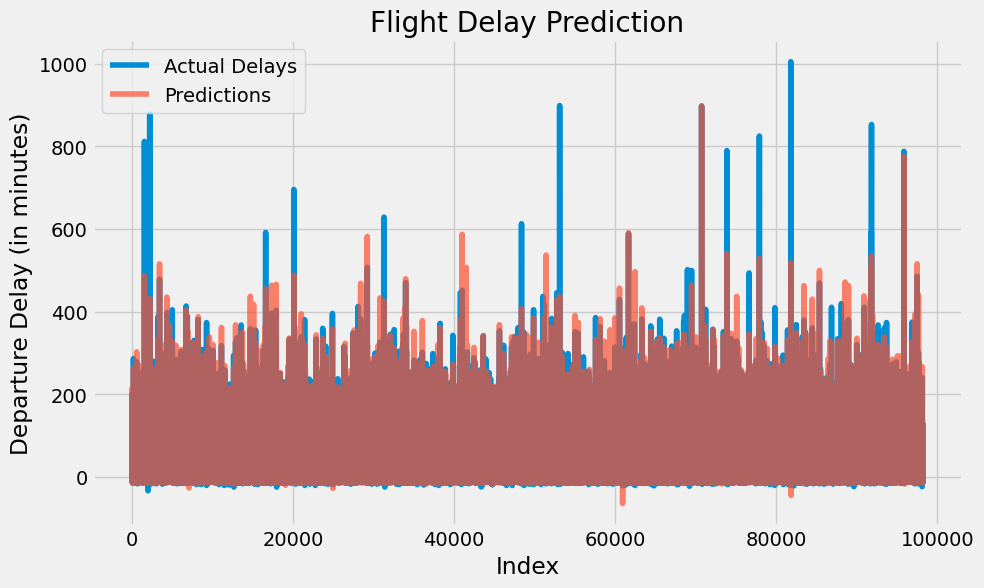

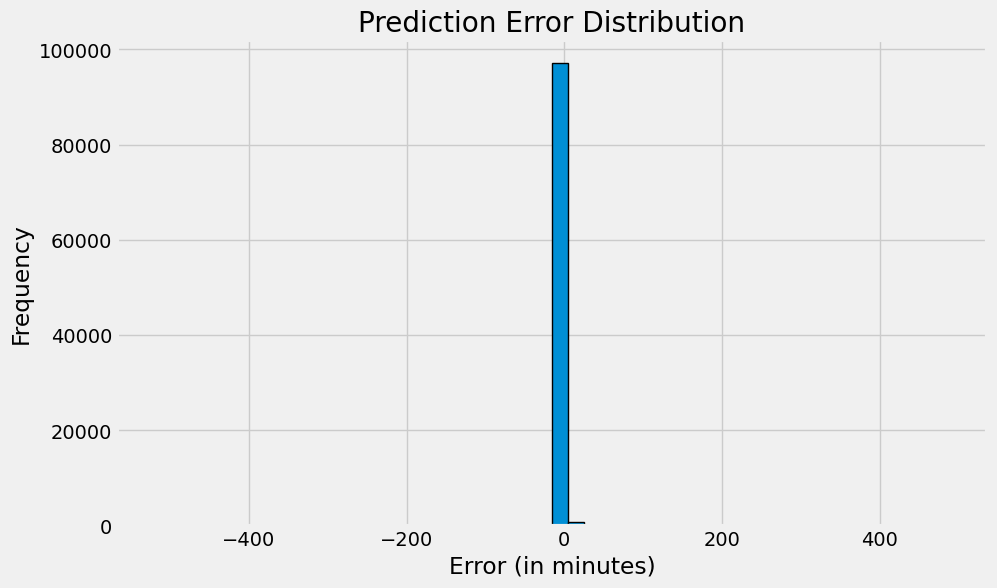

In [ ]:

# Calculate MSE and RMSE
mse = mean_squared_error(Y_test, predictions)
rmse = mse ** 0.5
print(f'MSE on test data: {mse:.2f}')
print(f'RMSE on test data: {rmse:.2f}')
# Graphical display
plt.figure(figsize=(10, 6))
plt.plot(range(len(Y_test)), Y_test.values, label="Actual Delays")
plt.plot(range(len(predictions)), predictions, label="Predictions", alpha=0.7)
plt.xlabel("Index")
plt.ylabel("Departure Delay (in minutes)")
plt.title("Flight Delay Prediction")
plt.legend()
plt.show()

# Display the distribution of errors
errors = Y_test - predictions
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, edgecolor='black')
plt.title('Prediction Error Distribution')
plt.xlabel('Error (in minutes)')
plt.ylabel('Frequency')
plt.show()



**2. Loading and Validating the Data**

Data is read from a CSV file.
The code checks for required columns (e.g., origin, destination, carrier, times, and delays) to ensure data integrity. Missing columns trigger an error.
Rows with missing values in key columns (scheduled/actual times) are dropped.

**3. Encoding and Feature Engineering**

Encoding Categorical Variables:
* Origin, destination, and carrier are converted into numerical values using LabelEncoder.

Time Features:
* Scheduled departure and arrival times are split into hours and minutes.

Seasonality:
* A binary column is_summer identifies peak summer months (June-August).

Delay Differences:
* delay_diff: Difference between scheduled and actual departure times.
* arrival_diff: Difference between scheduled and actual arrival times.

**4. Input (X) and Target (Y) Variables**

Features:
* Includes encoded variables, flight times, elapsed times, seasonal indicator, and delay differences.

Target:
* Departure delay (dep_delay).

**5. Data Splitting and Scaling**

The data is split into training (70%) and testing (30%) sets.

Features are normalized using StandardScaler for uniform scaling, crucial for XGBoost's performance.

**6. XGBoost Model and Hyperparameter Tuning**

XGBoost:
* An efficient gradient boosting model for regression.

Hyperparameter Optimization:
* A range of parameters (e.g., n_estimators, learning_rate, max_depth) is tested using RandomizedSearchCV.
* The best parameters are selected based on cross-validated performance.

**7. Model Evaluation**

Predictions:
* The best model predicts delays on the test set.

Metrics:
* MSE (Mean Squared Error) and RMSE (Root Mean Squared Error) quantify the model's performance.

Error Analysis:
* Errors (differences between actual and predicted delays) are plotted to check for patterns or biases.

**8. Visualizations**

Predictions vs. Actual Delays:
* A line plot compares predicted and actual delays.

Error Distribution:
* A histogram displays the spread of prediction errors.

**9. Model and Object Saving**
* The trained model and preprocessing objects (e.g., scalers, label encoders) are saved using joblib.
* Saved files (*.pkl) can be reused for predictions without retraining or preprocessing.



In [ ]:
import pandas as pd
import joblib
import numpy as np
import ipywidgets as widgets
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Load the pre-trained model and scaler
best_model = joblib.load('best_model.pkl')  # Ensure you have saved the model after training
scaler = joblib.load('scaler.pkl')  # Ensure you have saved the scaler after training

# Load the encoders (ensure you have saved the encoders after training)
label_encoder_origin = joblib.load('label_encoder_origin.pkl')
label_encoder_dest = joblib.load('label_encoder_dest.pkl')
label_encoder_carrier = joblib.load('label_encoder_carrier.pkl')

# Function to convert time into minutes since midnight
def time_to_minutes(time_column):
    return (time_column // 100) * 60 + (time_column % 100)

# Data preparation function
def prepare_data(new_data):
    # Convert schedules into minutes
    new_data['sched_dep_time_minutes'] = time_to_minutes(new_data['sched_dep_time'])
    new_data['sched_arr_time_minutes'] = time_to_minutes(new_data['sched_arr_time'])

    # Encode categorical values
    new_data['origin_encoded'] = label_encoder_origin.transform(new_data['origin'])
    new_data['dest_encoded'] = label_encoder_dest.transform(new_data['dest'])
    new_data['carrier_encoded'] = label_encoder_carrier.transform(new_data['carrier'])

    # Create seasonal features
    new_data['is_summer'] = new_data['month'].isin([6, 7, 8, 9]).astype(int)
    new_data['is_winter'] = new_data['month'].isin([11, 12, 1, 2]).astype(int)

    # Prepare the feature matrix
    X_new = new_data[['origin_encoded', 'dest_encoded', 'carrier_encoded', 'sched_dep_time_minutes',
                      'sched_arr_time_minutes', 'is_summer', 'is_winter']]

    # Scale the features
    X_new_scaled = scaler.transform(X_new)

    return X_new_scaled

# Create widgets for the user interface
origin_widget = widgets.Text(value='JFK', description='Origin:', disabled=False)
dest_widget = widgets.Text(value='LAX', description='Destination:', disabled=False)
carrier_widget = widgets.Text(value='AA', description='Carrier:', disabled=False)
sched_dep_time_widget = widgets.IntText(value=830, description='Scheduled Departure (HHMM):', disabled=False)
sched_arr_time_widget = widgets.IntText(value=1025, description='Scheduled Arrival (HHMM):', disabled=False)
month_widget = widgets.Dropdown(value=12, options=range(1, 13), description='Month:', disabled=False)
day_widget = widgets.Dropdown(value=15, options=range(1, 32), description='Day:', disabled=False)

# Prediction function
def predict_delay(_):
    # Create a DataFrame from widget values
    new_data = pd.DataFrame({
        'origin': [origin_widget.value],
        'dest': [dest_widget.value],
        'carrier': [carrier_widget.value],
        'sched_dep_time': [sched_dep_time_widget.value],
        'sched_arr_time': [sched_arr_time_widget.value],
        'year': [2013],  # Fix the year to 2013
        'month': [month_widget.value],
        'day': [day_widget.value]
    })

    # Prepare the data and make a prediction
    X_new_scaled = prepare_data(new_data)
    predicted_delay = best_model.predict(X_new_scaled)

    # Display the prediction
    print(f"The predicted flight delay is: {predicted_delay[0]:.2f} minutes")

# Create a button to trigger the prediction
predict_button = widgets.Button(description="Predict Delay")
predict_button.on_click(predict_delay)

# Display the user interface
widgets.VBox([origin_widget, dest_widget, carrier_widget, sched_dep_time_widget,
              sched_arr_time_widget, month_widget, day_widget, predict_button])


The predicted flight delay is: 7.62 minutes


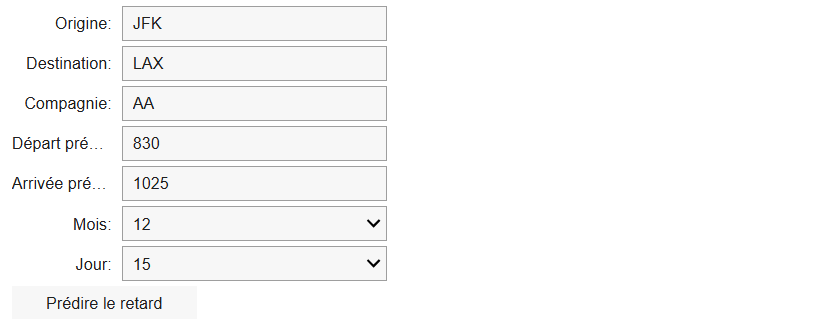

This code is about the interface construction

**1. Loading Resources**

The script loads several elements required for its functionality:

* Pre-trained Model: The best_model.pkl file contains the XGBoost model saved after training.
* Scaler: The scaler.pkl file is used to normalize data (an essential preprocessing step before making predictions).
* Encoders: The files label_encoder_origin.pkl, label_encoder_dest.pkl, and label_encoder_carrier.pkl contain the encoders used to convert categorical values (airports, airlines) into numerical format.

**2. Data Preparation**

The function prepare_data performs several steps:

* Time Conversion:
The time_to_minutes function converts times in HHMM format into minutes since midnight, making them easier for the model to interpret.

* Category Encoding:
The origin, dest, and carrier columns are transformed into integers using the saved encoders.

* Seasonal Columns:
Two additional columns, is_summer (summer) and is_winter (winter), are added to capture the seasonal effects on delays.

* Normalization:
The final features are standardized using the scaler.

**3. User Interface with ipywidgets**

The user interface consists of interactive widgets:

* Text Inputs: For the origin, destination, and airline.
* Numerical Fields: For scheduled departure and arrival times (sched_dep_time and sched_arr_time).
* Dropdown Menus: To select the month and day.

A prediction button triggers the predict_delay function, which:
* Reads the values from the widgets to create a DataFrame.
* Prepares the data using the prepare_data function.
* Makes a prediction using the XGBoost model.
* Displays the predicted delay in minutes.

**4. Displaying the Interface**

The complete interface is displayed in an environment compatible with Jupyter Notebook

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib
import numpy as np

# Load flight data
df = pd.read_csv('flight_data.csv')  # Replace with the file path

# Check that the required columns are present
required_columns = ['origin', 'dest', 'carrier', 'sched_dep_time', 'dep_time',
                    'sched_arr_time', 'arr_time', 'year', 'month', 'day', 'dep_delay',
                    'sched_time', 'elapse_time']
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Missing column: {col}")

# Drop rows with NaN values after conversion
df.dropna(subset=['sched_dep_time', 'sched_arr_time', 'dep_time', 'arr_time'], inplace=True)

# Remove negative or abnormal delays
df = df[df['dep_delay'] >= 0]

# Convert times to minutes since midnight
def time_to_minutes(time_column):
    return (time_column // 100) * 60 + (time_column % 100)

df['sched_dep_time_minutes'] = time_to_minutes(df['sched_dep_time'])
df['sched_arr_time_minutes'] = time_to_minutes(df['sched_arr_time'])
df['dep_time_minutes'] = time_to_minutes(df['dep_time'])
df['arr_time_minutes'] = time_to_minutes(df['arr_time'])

# Encode origins, destinations, and carriers
label_encoder_origin = LabelEncoder()
label_encoder_dest = LabelEncoder()
label_encoder_carrier = LabelEncoder()

# Encode the values
df['origin_encoded'] = label_encoder_origin.fit_transform(df['origin'])
df['dest_encoded'] = label_encoder_dest.fit_transform(df['dest'])
df['carrier_encoded'] = label_encoder_carrier.fit_transform(df['carrier'])

# Save the encoders
joblib.dump(label_encoder_origin, 'label_encoder_origin.pkl')
joblib.dump(label_encoder_dest, 'label_encoder_dest.pkl')
joblib.dump(label_encoder_carrier, 'label_encoder_carrier.pkl')

# Create the 'date' column from year, month, and day
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

# Create a column for seasonality (e.g., high season = summer)
df['is_summer'] = df['month'].isin([6, 7, 8, 9]).astype(int)
df['is_winter'] = df['month'].isin([11, 12, 1, 2]).astype(int)

# Create new features
X = df[['origin_encoded', 'dest_encoded', 'carrier_encoded', 'sched_dep_time_minutes',
        'sched_arr_time_minutes', 'is_summer', 'is_winter']]

# Target departure delays
Y = df['dep_delay']  # The target variable is 'dep_delay' (actual delay)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Parameters to test with RandomizedSearch
param_dist = {
    'n_estimators': [1000, 1500, 2000, 2500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'max_depth': [5, 7, 9, 11],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5],
    'lambda': [0, 1, 2]
}

# Randomized search for the best hyperparameters
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=50, cv=5,
                                   scoring='neg_mean_squared_error', verbose=1, random_state=42, n_jobs=-1)
random_search.fit(X_train_scaled, Y_train)

# Display the best parameters
print("Best parameters found: ", random_search.best_params_)

# Save the optimized model to a .pkl file
joblib.dump(random_search.best_estimator_, 'best_model.pkl')

# Predictions with the best model
best_model = random_search.best_estimator_
predictions = best_model.predict(X_test_scaled)

# Calculate MSE and RMSE
mse = mean_squared_error(Y_test, predictions)
rmse = mse ** 0.5
print(f'MSE on test data: {mse:.2f}')
print(f'RMSE on test data: {rmse:.2f}')

# Calculate mean absolute error (MAE)
mae = mean_absolute_error(Y_test, predictions)
print(f'MAE on test data: {mae:.2f}')

# Calculate the percentage error for each prediction (ignore zero delays)
percentage_error = np.where(Y_test != 0, np.abs((Y_test - predictions) / Y_test) * 100, 0)
print(f'Average percentage error (excluding zero delays): {percentage_error[Y_test != 0].mean():.2f}%')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(len(Y_test)), Y_test.values, label="Actual Delays")
plt.plot(range(len(predictions)), predictions, label="Predictions", alpha=0.7)
plt.xlabel("Index")
plt.ylabel("Departure Delay (in minutes)")
plt.title("Flight Delay Predictions")
plt.legend()
plt.show()

# Display the distribution of errors
errors = Y_test - predictions
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, edgecolor='black')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error (in minutes)')
plt.ylabel('Frequency')
plt.show()


Average percentage error (excluding zero delays): 4.38%


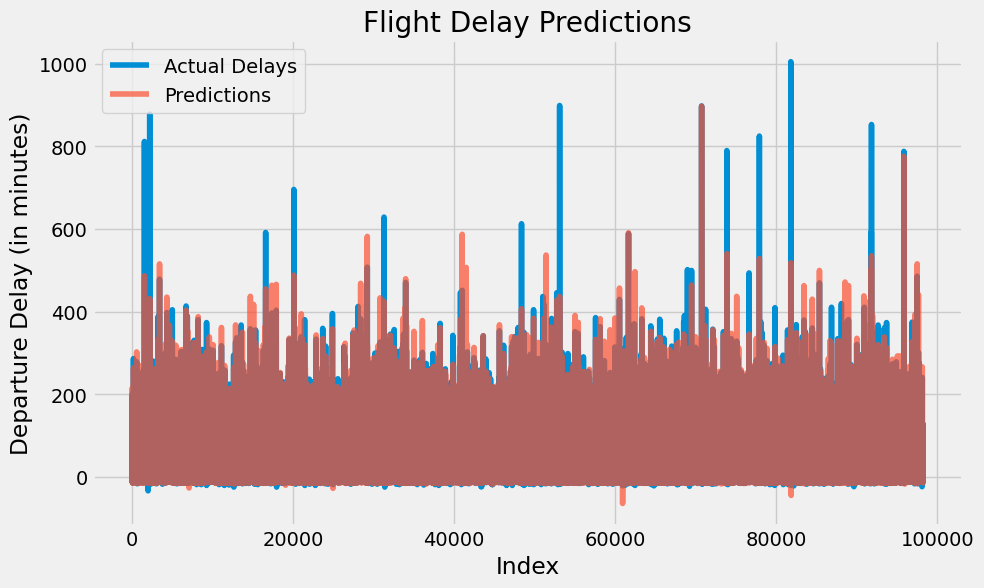

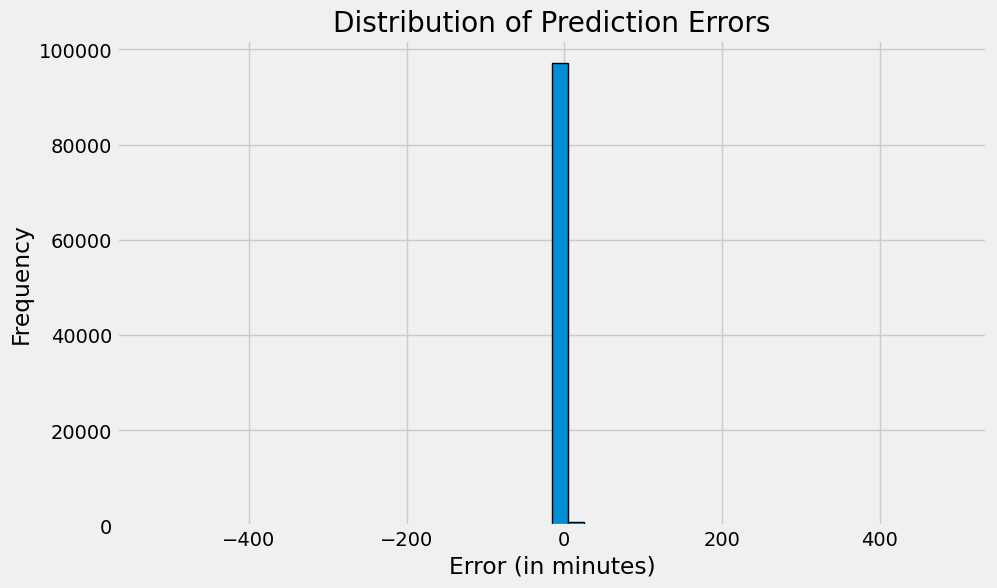

In [ ]:

# Calculate the percentage error for each prediction (ignore zero delays)
percentage_error = np.where(Y_test != 0, np.abs((Y_test - predictions) / Y_test) * 100, 0)
print(f'Average percentage error (excluding zero delays): {percentage_error[Y_test != 0].mean():.2f}%')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(len(Y_test)), Y_test.values, label="Actual Delays")
plt.plot(range(len(predictions)), predictions, label="Predictions", alpha=0.7)
plt.xlabel("Index")
plt.ylabel("Departure Delay (in minutes)")
plt.title("Flight Delay Predictions")
plt.legend()
plt.show()

# Display the distribution of errors
errors = Y_test - predictions
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, edgecolor='black')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error (in minutes)')
plt.ylabel('Frequency')
plt.show()
